In [2]:
import pandas

In [11]:
sns.set_style('whitegrid')

In [12]:
def get_condition(row):
    
    even = not (row.subject_id % 2)
    
    if row.subject_id == 0:
        even = False
    
    if np.isnan(row['syncvalue[SubTrial]']):
        return np.nan
    
#     print row
    
    if even:
        return {11:'cs-', 12:'cs+', 14:'shock', np.nan:np.nan}[row['syncvalue[SubTrial]']]
    else:
        return {11:'cs+', 12:'cs-', 13:'shock', np.nan:np.nan}[row['syncvalue[SubTrial]']]
    

In [13]:
df = pandas.read_excel('/home/gdholla1/data/daphne/behavior/Task1_All Participants.xlsx')
df.ix[df.Subject == 'P05', 'subject'] = 0

df['onset'] = df['face3sec.OnsetTime'] - df['Waitforscanner1c.RTTime']
df['onset'] /= 1000

# df['condition'] = df['syncvalue[SubTrial]']

# df['condition'] = df['condition'].map({11:'cs+', 12:'cs-', 13:'shock'})

df.ix[df.Subject == 'P05', 'Subject'] = 0

df['subject_id'] = df.Subject.astype(int)

df['condition'] = df.apply(get_condition, 1)

In [14]:
df.to_pickle('/home/gdholla1/data/daphne/behavior/all_data.pandas')

In [15]:
import pyfir

In [16]:
def get_signal(subject_id, mask, mask_type='disjunct', interpolation='nearestneighbour', phys_filtered=False):

    signal = np.loadtxt('/home/gdholla1/data/daphne/mni_masks/extracted_signal/_subject_id_S%02d/_mask_%s/_extract_weighted_phys0/run1_maths_maths_maths_dtype_mcf_mask_gms_tempfilt_regfilt_maths_weighted.txt' % (subject_id, mask))
    
    signal = (signal / signal.mean()) * 100
    signal -= signal.mean()
    
    return signal

In [17]:
def get_onsets(subject_id, kind='simple'):
    
    df = pandas.read_pickle('/home/gdholla1/data/daphne/behavior/all_data.pandas')
    
    df = df[df.Subject == subject_id]
    df = df[~df.condition.isnull()]    
    
    if kind == 'simple':    
        onsets = {'cs+':df[df.condition == 'cs+'].onset.tolist(),
                  'cs-':df[df.condition == 'cs-'].onset.tolist(),
                  'shock':df[df.condition == 'shock'].onset.tolist()}
        
 
    if kind == 'single_trial':
        
        
        tmp = df.ix[df.condition == 'shock'].copy()
        tmp['onset'] += 3
        
        df.ix[df.condition == 'shock', 'condition'] = 'cs+'
    
        df = pandas.concat((df, tmp), ignore_index=True)
        
        df['single_trial_condition'] = df.groupby('condition').apply(lambda d: pandas.DataFrame(['%s.%d' % (row.condition, i+1) for i, (_, row) in enumerate(d.iterrows())], index=d.index))
        
        onsets = zip(df.single_trial_condition, df.onset)

        onsets = dict([(key, [value]) for key, value in onsets])
        
    
    if kind == 'deconvolve_shock_cs+':
        
        tmp = df.ix[df.condition == 'shock'].copy()
        tmp['onset'] += 3
        
        df.ix[df.condition == 'shock', 'condition'] = 'cs+'
    
        df = pandas.concat((df, tmp), ignore_index=True)
        
        onsets = {'cs+':df[df.condition == 'cs+'].onset.tolist(),
                  'cs-':df[df.condition == 'cs-'].onset.tolist(),
                  'shock':df[df.condition == 'shock'].onset.tolist()}
    
    return onsets
    
    
    

In [18]:
df.subject_id.unique().shape

(12,)

In [19]:
masks = ['STh_L', 'STh_R', 'SN_L', 'SN_R', 'RN_L', 'RN_R', 'GPi_L', 'GPi_R', 'PAG']

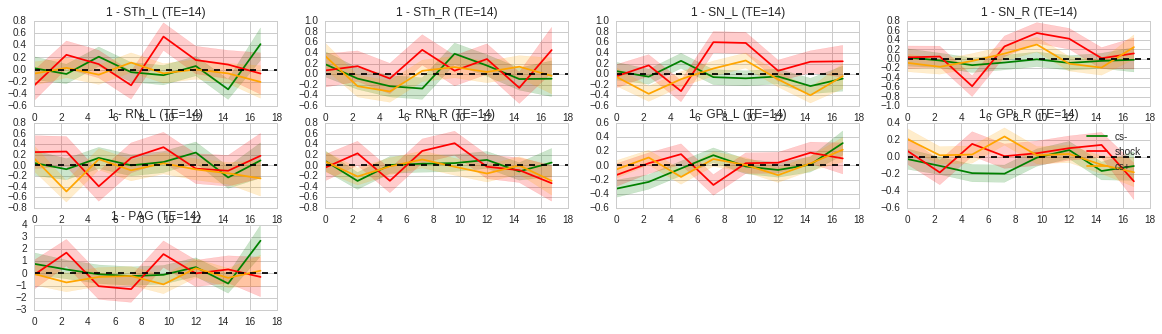

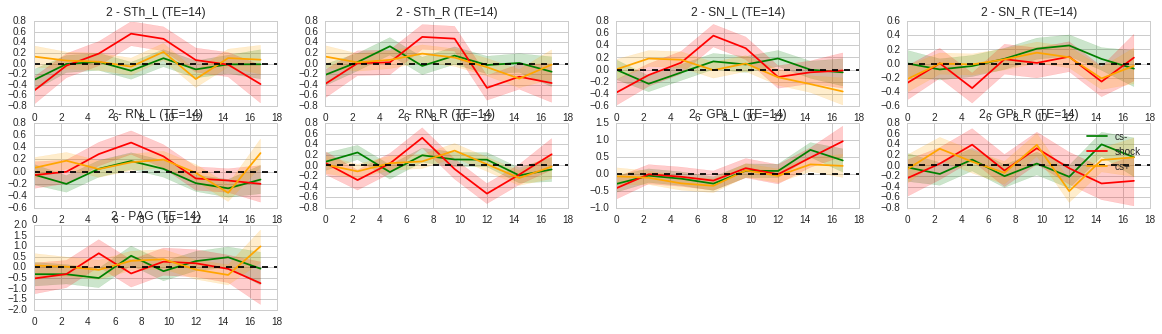

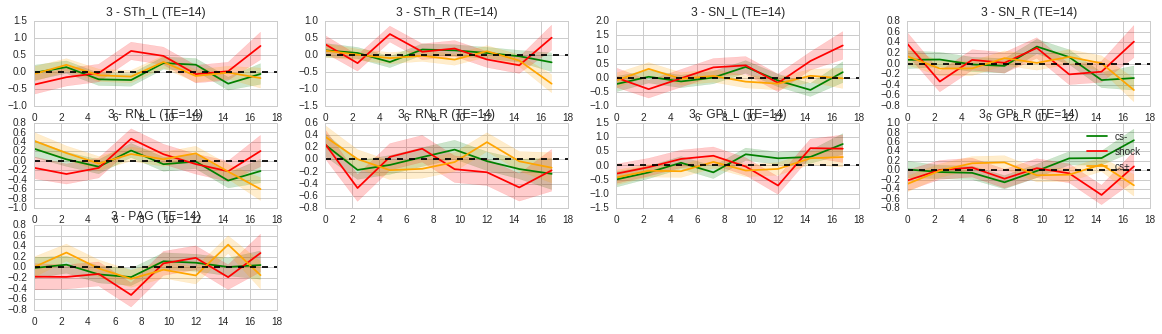

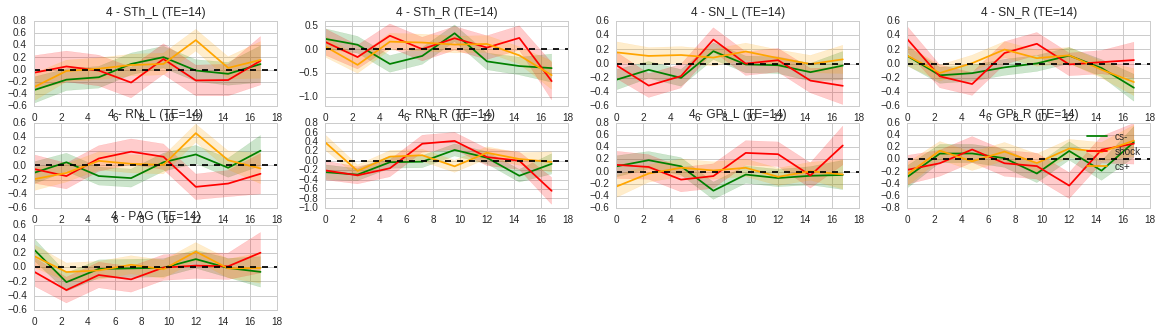

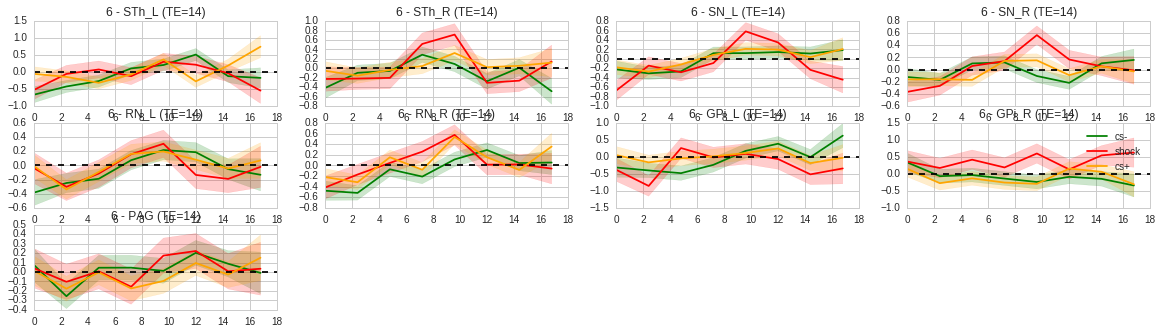

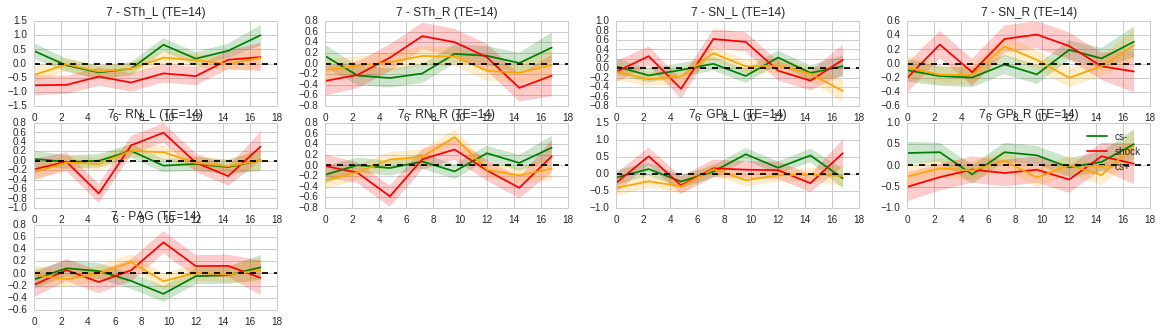

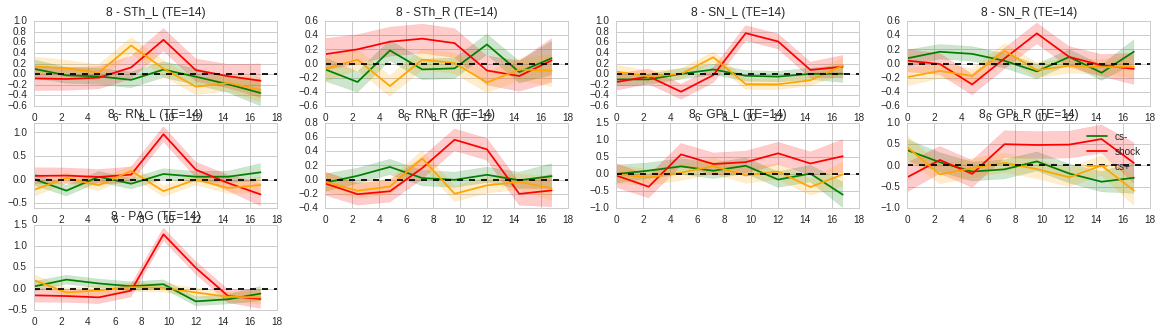

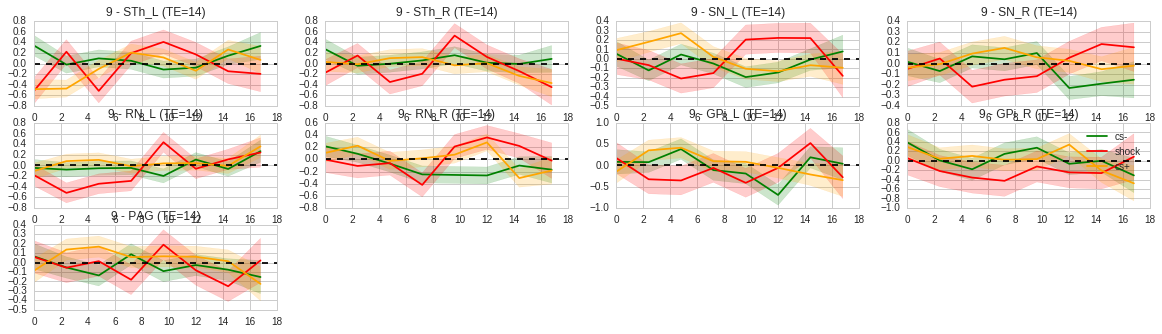

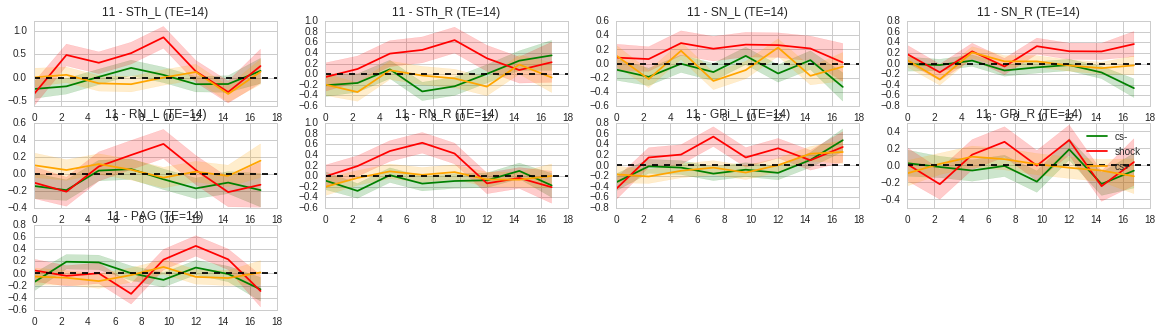

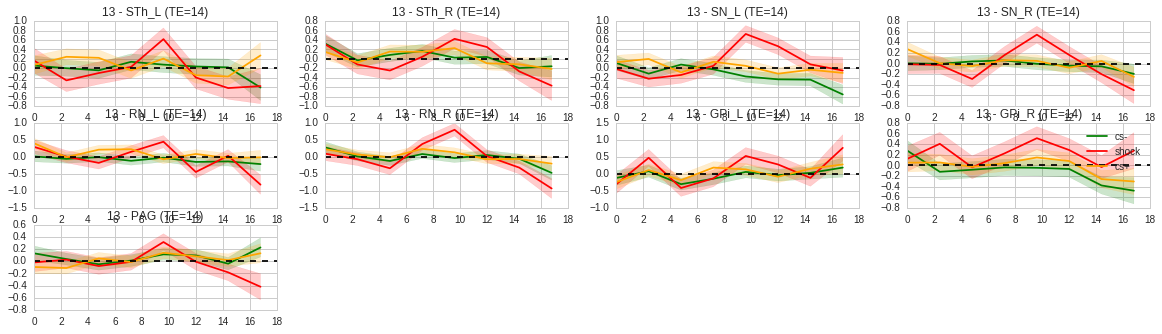

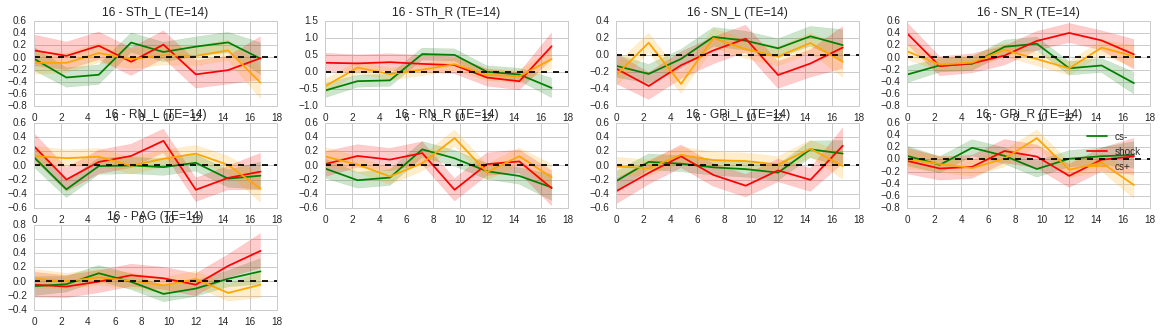

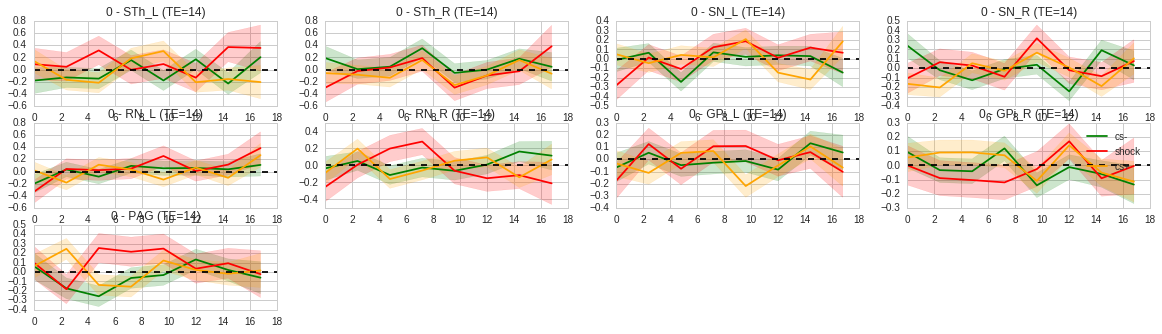

In [20]:
firs = []

for subject_id in df.subject_id.unique():
    plt.figure(figsize=(20, 7))
    for i, mask in enumerate(masks):
        
        try:
            signal = get_signal(subject_id, mask, interpolation='weighted', mask_type='disjunct', phys_filtered=False)
            onsets = get_onsets(subject_id)


            if onsets:
                fir = pyfir.FIR(signal)
                r = fir.fit(onsets, 1.2, resolution = 2.4, len_impulse=18)

                plt.subplot(4, 4, i+1)
                plt.title('%s - %s (TE=14)' % (subject_id, mask))
                r.plot_results({'shock':'red',
                                'cs+':'orange',
                                'cs-':'green',})
                #plt.ylim(-1, 1)

                if i != 7:
                    plt.gca().legend_.remove()

                for condition, hrf in zip(r.conditions, r.beta):
                    for time, value in zip(r.times, hrf):
                        firs.append({'mask':mask,
                                     'subject_id':subject_id,
                                     'condition':condition,
                                     't':time,
                                     'value':value})


        except Exception as e:
            print 'Error with %s/%s - %s' % (subject_id, mask, e)

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


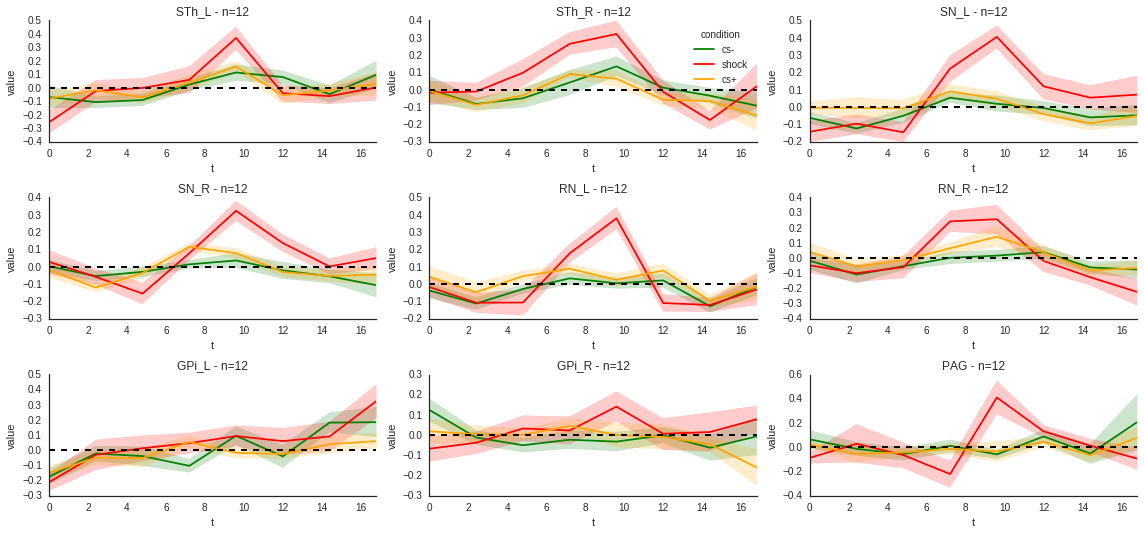

In [21]:
df_firs = pandas.DataFrame(firs)
df_firs = df_firs[~df_firs.value.isnull()]
sns.set_palette(['green', 'red','orange', ])
plt.figure(figsize=(16, 12))

sns.set_style('white')


# for i, ((te, mask), d) in enumerate(df_firs.groupby(['TE', 'mask'], sort=False)):

# yticks = np.arange(-0.3, 0.51, .1).round(1)

for i, mask in enumerate(masks):
    plt.subplot(5, 3, i+1)
#     plt.ylim(-.3, .5)
    sns.tsplot(df_firs[(df_firs['mask'] == mask)], unit='subject_id', time='t', value='value', condition='condition', ci=67)
    
    if i != 1:
        plt.gca().legend_.remove()
        
    plt.title('%s - n=%d' % (mask, df_firs[(df_firs['mask'] == mask)].subject_id.unique().shape[0]))
    plt.axhline(0, lw=2, ls='--', c='k')
    
#     if i < 5:
#         plt.xticks(plt.xticks()[0], [''] * len(plt.xticks()[0]))
#         plt.xlabel('')
#     else:
#         plt.xlabel('t (s)')
        
#     if i % 5 == 0:
#         plt.ylabel('% signal change')
        
#         plt.yticks(yticks, yticks)
#     else:
#         plt.yticks(yticks, [''] * len(yticks))
#         plt.ylabel('')
    
# plt.suptitle('Mean signal over all %s subjects' % df_firs.subject_id.unique().shape, fontsize=24)

plt.tight_layout()
plt.savefig('all_nuclei.pdf', transparent=True)
sns.despine()

In [22]:
df_firs.groupby(['mask', 'subject_id']).size()

mask   subject_id
GPi_L  0             24
       1             24
       2             24
       3             24
       4             24
       6             24
       7             24
       8             24
       9             24
       11            24
       13            24
       16            24
GPi_R  0             24
       1             24
       2             24
       3             24
       4             24
       6             24
       7             24
       8             24
       9             24
       11            24
       13            24
       16            24
PAG    0             24
       1             24
       2             24
       3             24
       4             24
       6             24
                     ..
SN_R   7             24
       8             24
       9             24
       11            24
       13            24
       16            24
STh_L  0             24
       1             24
       2             24
       3             2

In [23]:
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

sns.set_palette('deep')

level2_dict = []
adj_r = []

pars = ['cs+', 'cs-', 'shock']

for subject_id in df.subject_id.unique():


    onsets_dict = get_onsets(subject_id, kind='deconvolve_shock_cs+')
    
    if onsets_dict:
        conditions = []
        onsets = []
        for key in onsets_dict.keys():
            conditions += [key] * len(onsets_dict[key])
            onsets += onsets_dict[key]

        paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                        onset=onsets,
                                                        duration=[[3.]] * len(conditions))
        try:
            signal = get_signal(subject_id, 'STh_L')
            tr = 1.2
            frametimes = np.arange(0, signal.shape[-1] * tr, tr)
            print frametimes.shape
            hrf_model = 'Canonical with Derivative'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=3)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)
        
        except Exception as e:
            pass

        for i, (mask, d) in enumerate(df_firs.groupby(['mask'])):
            
            try:
                signal = get_signal(subject_id, mask)
                print subject_id, mask, signal.shape, X.shape
                r = sm.GLSAR(signal, X).iterative_fit()


                
                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask})
            except Exception as e:
                print e
                print 'Problem withs %s %s' % (subject_id, mask)
                
            
        plt.suptitle(subject_id, fontsize=24)

(495,)
1 GPi_L (495,) (495, 10)
1 GPi_R (495,) (495, 10)
1 PAG (495,) (495, 10)
1 RN_L (495,) (495, 10)
1 RN_R (495,) (495, 10)
1 SN_L (495,) (495, 10)
1 SN_R (495,) (495, 10)
1 STh_L (495,) (495, 10)
1 STh_R (495,) (495, 10)
(495,)
2 GPi_L (495,) (495, 10)


/usr/local/lib/python2.7/dist-packages/nipy/modalities/fmri/design_matrix.py:191: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if rmatrix == None:


2 GPi_R (495,) (495, 10)
2 PAG (495,) (495, 10)
2 RN_L (495,) (495, 10)
2 RN_R (495,) (495, 10)
2 SN_L (495,) (495, 10)
2 SN_R (495,) (495, 10)
2 STh_L (495,) (495, 10)
2 STh_R (495,) (495, 10)
(496,)
3 GPi_L (496,) (496, 10)
3 GPi_R (496,) (496, 10)
3 PAG (496,) (496, 10)
3 RN_L (496,) (496, 10)
3 RN_R (496,) (496, 10)
3 SN_L (496,) (496, 10)
3 SN_R (496,) (496, 10)
3 STh_L (496,) (496, 10)
3 STh_R (496,) (496, 10)
(496,)
4 GPi_L (496,) (496, 10)
4 GPi_R (496,) (496, 10)
4 PAG (496,) (496, 10)
4 RN_L (496,) (496, 10)
4 RN_R (496,) (496, 10)
4 SN_L (496,) (496, 10)
4 SN_R (496,) (496, 10)
4 STh_L (496,) (496, 10)
4 STh_R (496,) (496, 10)
(495,)
6 GPi_L (495,) (495, 10)
6 GPi_R (495,) (495, 10)
6 PAG (495,) (495, 10)
6 RN_L (495,) (495, 10)
6 RN_R (495,) (495, 10)
6 SN_L (495,) (495, 10)
6 SN_R (495,) (495, 10)
6 STh_L (495,) (495, 10)
6 STh_R (495,) (495, 10)
(499,)
7 GPi_L (499,) (499, 10)
7 GPi_R (499,) (499, 10)
7 PAG (499,) (499, 10)
7 RN_L (499,) (499, 10)
7 RN_R (499,) (499, 10)


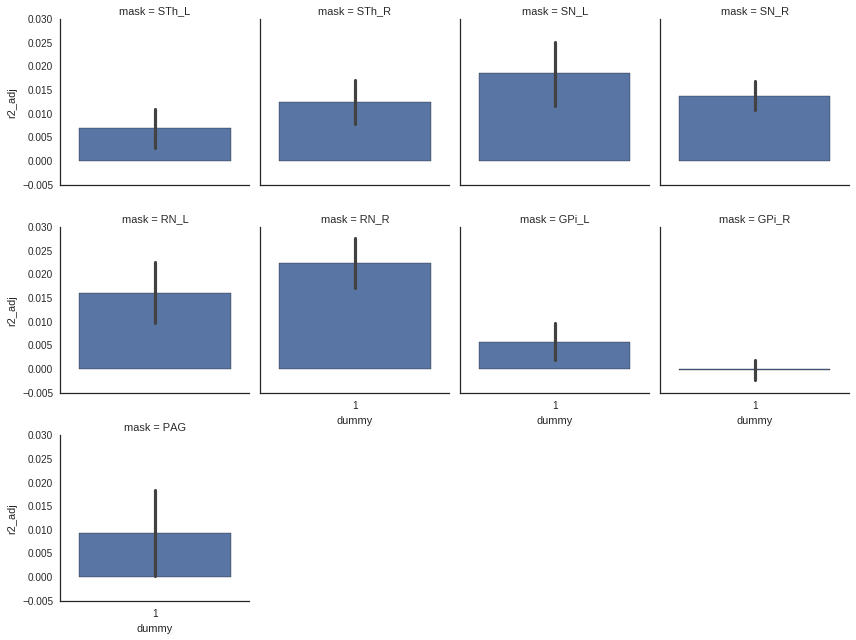

In [24]:
adj_r = pandas.DataFrame(adj_r)
adj_r['dummy'] = 1

f = sns.factorplot(x='dummy', y='r2_adj', data=adj_r, col='mask', col_wrap=4, size=3, units='subject_id',
                   col_order=df_firs['mask'].unique(),
            kind='bar',
                  ci=67)

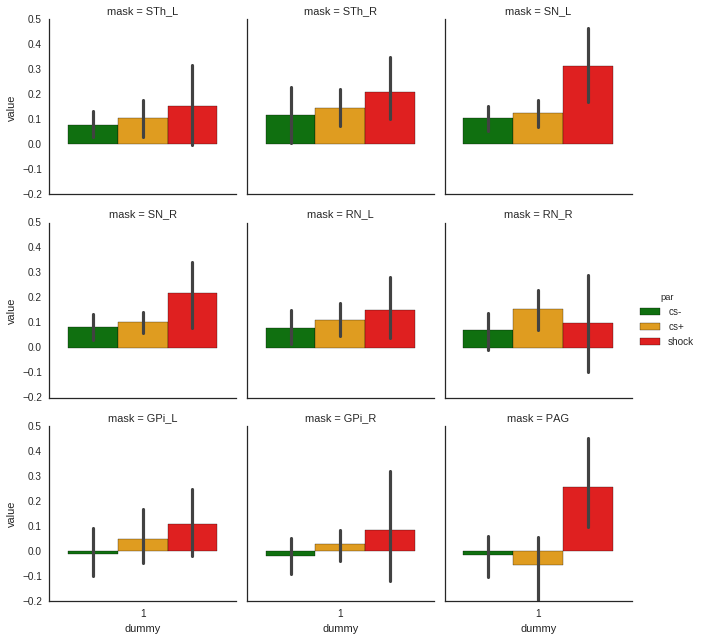

In [25]:
df_glm = pandas.DataFrame(level2_dict)
df_glm = df_glm.query('par != "constant"')
df_glm['dummy'] = 1
#sns.set_palette('husl', 4)
f = sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, size=3,
              palette=['green', 'orange', 'red'],
                   col_order=masks,
              hue_order=['cs-', 'cs+', 'shock'],
            kind='bar',
                  ci=95)

In [27]:
%load_ext rpy2.ipython

In [28]:
tmp = []

for (mask, condition), d in df_glm.groupby(['mask', 'par']):
    values = d.value.values
    print mask, condition
    %%R -i d -i values
    %%R library(BayesFactor)
    %%R bf = ttestBF(values, nullInterval=c(0,Inf))
#     %%R print(bf)
    %%R bf = as.vector(bf)
    %%R -o bf
    tmp.append({'mask':mask, 'condition':condition, 'BF':bf[0]})

GPi_L cs+


/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: coda

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: ************
Welcome to BayesFactor 0.9.11-1. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************

  warnings.warn(x, RRuntimeWarning)


GPi_L cs-
GPi_L shock
GPi_R cs+
GPi_R cs-
GPi_R shock
PAG cs+
PAG cs-
PAG shock
RN_L cs+
RN_L cs-
RN_L shock
RN_R cs+
RN_R cs-
RN_R shock
SN_L cs+
SN_L cs-
SN_L shock
SN_R cs+
SN_R cs-
SN_R shock
STh_L cs+
STh_L cs-
STh_L shock
STh_R cs+
STh_R cs-
STh_R shock


In [29]:
np.round(pandas.DataFrame(tmp).pivot_table(index='mask', columns=['condition'])['BF'].ix[:, ['cs-', 'cs+', 'shock']], 2)

,cs-,cs+,shock
mask,,,
GPi_L,0.25,0.62,1.25
GPi_R,0.20,0.56,0.55
PAG,0.22,0.17,6.50
RN_L,3.27,11.50,3.72
RN_R,1.81,23.35,0.69
SN_L,41.20,70.42,46.15
SN_R,9.59,84.88,10.24
STh_L,6.41,4.97,1.76
STh_R,2.19,26.21,13.24


In [30]:
tmp = []

for (mask), d in df_glm.groupby(['mask']):
    values = d[d.par == 'cs+'].value.values - d[d.par == 'cs-'].value.values
    print mask, condition
    %%R -i d -i values
    %%R library(BayesFactor)
    %%R bf = ttestBF(values, nullInterval=c(0,Inf))
#     %%R print(bf)
    %%R bf = as.vector(bf)
    %%R -o bf
    tmp.append({'mask':mask, 'condition':'cs+ > cs-', 'BF':bf[0]})
    
    
    values = d[d.par == 'shock'].value.values - d[d.par == 'cs+'].value.values
    print mask, condition
    %%R -i d -i values
    %%R library(BayesFactor)
    %%R bf = ttestBF(values, nullInterval=c(0,Inf))
#     %%R print(bf)
    %%R bf = as.vector(bf)
    %%R -o bf
    tmp.append({'mask':mask, 'condition':'shock > cs+', 'BF':bf[0]})

GPi_L shock
GPi_L shock
GPi_R shock
GPi_R shock
PAG shock
PAG shock
RN_L shock
RN_L shock
RN_R shock
RN_R shock
SN_L shock
SN_L shock
SN_R shock
SN_R shock
STh_L shock
STh_L shock
STh_R shock
STh_R shock


In [31]:
tmp = pandas.DataFrame(tmp)

In [32]:
np.round( pandas.DataFrame(tmp).pivot_table(index='mask', columns=['condition'])['BF'], 2)

,cs+ > cs-,shock > cs+
mask,,
GPi_L,0.97,0.52
GPi_R,0.76,0.42
PAG,0.18,3.41
RN_L,0.75,0.43
RN_R,1.99,0.21
SN_L,0.46,2.99
SN_R,0.43,1.25
STh_L,0.55,0.49
STh_R,0.45,0.54
